In [1]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv(dotenv_path="/home/jovyan/work/.env")

PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB = os.getenv("PG_DB")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_SCHEMA_RAW = os.getenv("PG_SCHEMA_RAW")
PG_SCHEMA_ANALYTICS = os.getenv("PG_SCHEMA_ANALYTICS")


In [3]:
spark = SparkSession.builder \
    .appName("DataLoad") \
    .config("spark.jars", "/home/jovyan/work/jars/postgresql-42.7.3.jar") \
    .getOrCreate()

pgOptions = {
    "url": f"jdbc:postgresql://{PG_HOST}:{PG_PORT}/{PG_NAME}",
    "user": PG_USER,
    "password": PG_PASSWORD,
    "driver": "org.postgresql.Driver"
}



In [4]:
## Columnas para limpieza desde OBT

In [4]:
cols_keep = [
'vendor_name', 'trip_distance', 'passenger_count', 'rate_code_desc', 'total_amount', 'service_type', 'pickup_dow', 'pickup_month', 'pickup_year', 'pickup_hour', 'is_weekend', 'is_rush_hour', 'pickup_zone', 'pickup_borough'
]

In [ ]:
## Prueba 1: Cargar muestras aleatorias

In [5]:
def load_sample(service, year, n=10000):
    query = f"""
        (SELECT {', '.join(cols_keep)} FROM analytics.obt_trips
         WHERE "service_type"='{service}' AND "pickup_year"={year}
         LIMIT {n}) AS tmp
    """
    return spark.read.jdbc(url=pgOptions["url"], table=query, properties=pgOptions)



In [6]:
print("Creando DataFrames de entrenamiento, validación y prueba...")
print("Creando 2016")
# 2016
df_2016_green  = load_sample("green", 2016, n=250000)

print("Creando 2017")
# 2017
df_2017_green  = load_sample("green", 2017, n=250000)

# Unir ambos años para train
df_train_green = df_2016_green.union(df_2017_green)


print("Creando 2018")
# 2018 validation
df_val_green  = load_sample("green", 2018, n=250000)


print("Creando 2019")
# 2019 test
df_test_green  = load_sample("green", 2019, n=250000)

print("DataFrames cargados desde Postgres: ")


Creando DataFrames de entrenamiento, validación y prueba...
Creando 2016
Creando 2017
Creando 2018
Creando 2019
DataFrames cargados desde Postgres: 


In [ ]:
## Green

In [7]:
df_train_green = df_train_green.toPandas()
df_val_green = df_val_green.toPandas()
df_test_green = df_test_green.toPandas()


In [8]:
df_all_green = pd.concat([df_train_green, df_val_green, df_test_green], ignore_index=True)

In [9]:
#Cambiar los tipos de datos
columnas_a_convertir = ["trip_distance", "total_amount"] 

for col in columnas_a_convertir:
    df_all_green[col] = pd.to_numeric(df_all_green[col], errors='coerce').astype('float64')

In [10]:
#Conocer los datos
print(f"Shape: {df_all_green.shape}")
print(df_all_green.info())


Shape: (1000000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   vendor_name      1000000 non-null  object 
 1   trip_distance    1000000 non-null  float64
 2   passenger_count  980461 non-null   float64
 3   rate_code_desc   980461 non-null   object 
 4   total_amount     1000000 non-null  float64
 5   service_type     1000000 non-null  object 
 6   pickup_dow       1000000 non-null  int32  
 7   pickup_month     1000000 non-null  int32  
 8   pickup_year      1000000 non-null  int32  
 9   pickup_hour      1000000 non-null  int32  
 10  is_weekend       1000000 non-null  bool   
 11  is_rush_hour     1000000 non-null  bool   
 12  pickup_zone      1000000 non-null  object 
 13  pickup_borough   1000000 non-null  object 
dtypes: bool(2), float64(3), int32(4), object(5)
memory usage: 78.2+ MB
None


In [11]:
df_all_green.to_parquet(path="df_all_green.parquet", index=False)

In [12]:
#Conocimiento de nulos.
nulos = df_all_green.isnull().sum()
print(nulos[nulos > 0])
print(f"\nFilas duplicadas: {df_all_green.duplicated().sum()}")

passenger_count    19539
rate_code_desc     19539
dtype: int64

Filas duplicadas: 68254


In [13]:
df_all_green[df_all_green['passenger_count'].isnull()]

,vendor_name,trip_distance,passenger_count,rate_code_desc,total_amount,service_type,pickup_dow,pickup_month,pickup_year,pickup_hour,is_weekend,is_rush_hour,pickup_zone,pickup_borough
500000,"Curb Mobility, LLC",5.03,NaN,None,32.50,green,6,8,2018,9,False,True,Erasmus,Brooklyn
500001,"Curb Mobility, LLC",6.28,NaN,None,36.00,green,6,8,2018,10,False,True,Bronxdale,Bronx
500002,"Curb Mobility, LLC",6.95,NaN,None,39.50,green,5,8,2018,12,False,False,Jamaica,Queens
500003,"Curb Mobility, LLC",8.83,NaN,None,46.50,green,7,8,2018,10,True,True,Steinway,Queens
500004,"Curb Mobility, LLC",10.06,NaN,None,49.20,green,4,8,2018,11,False,False,Hunts Point,Bronx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993066,"Curb Mobility, LLC",9.42,NaN,None,31.79,green,7,8,2019,22,True,False,Bayside,Queens
993067,"Curb Mobility, LLC",7.27,NaN,None,36.35,green,7,8,2019,22,True,False,Hunts Point,Bronx
996331,"Curb Mobility, LLC",14.97,NaN,None,62.70,green,5,5,2019,9,False,True,Corona,Queens
996811,"Curb Mobility, LLC",8.26,NaN,None,43.00,green,5,5,2019,14,False,False,Fort Greene,Brooklyn


In [15]:
df_all_green[df_all_green['rate_code_desc'].isnull()]

,vendor_name,trip_distance,passenger_count,rate_code_desc,total_amount,service_type,pickup_dow,pickup_month,pickup_year,pickup_hour,is_weekend,is_rush_hour,pickup_zone,pickup_borough
500000,"Curb Mobility, LLC",5.03,NaN,None,32.50,green,6,8,2018,9,False,True,Erasmus,Brooklyn
500001,"Curb Mobility, LLC",6.28,NaN,None,36.00,green,6,8,2018,10,False,True,Bronxdale,Bronx
500002,"Curb Mobility, LLC",6.95,NaN,None,39.50,green,5,8,2018,12,False,False,Jamaica,Queens
500003,"Curb Mobility, LLC",8.83,NaN,None,46.50,green,7,8,2018,10,True,True,Steinway,Queens
500004,"Curb Mobility, LLC",10.06,NaN,None,49.20,green,4,8,2018,11,False,False,Hunts Point,Bronx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993066,"Curb Mobility, LLC",9.42,NaN,None,31.79,green,7,8,2019,22,True,False,Bayside,Queens
993067,"Curb Mobility, LLC",7.27,NaN,None,36.35,green,7,8,2019,22,True,False,Hunts Point,Bronx
996331,"Curb Mobility, LLC",14.97,NaN,None,62.70,green,5,5,2019,9,False,True,Corona,Queens
996811,"Curb Mobility, LLC",8.26,NaN,None,43.00,green,5,5,2019,14,False,False,Fort Greene,Brooklyn


In [ ]:
#Prueba 1.1: Eliminar nulos

In [16]:
df_all_green_dn = df_all_green.dropna()

In [17]:
df_all_green_dn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 980461 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   vendor_name      980461 non-null  object 
 1   trip_distance    980461 non-null  float64
 2   passenger_count  980461 non-null  float64
 3   rate_code_desc   980461 non-null  object 
 4   total_amount     980461 non-null  float64
 5   service_type     980461 non-null  object 
 6   pickup_dow       980461 non-null  int32  
 7   pickup_month     980461 non-null  int32  
 8   pickup_year      980461 non-null  int32  
 9   pickup_hour      980461 non-null  int32  
 10  is_weekend       980461 non-null  bool   
 11  is_rush_hour     980461 non-null  bool   
 12  pickup_zone      980461 non-null  object 
 13  pickup_borough   980461 non-null  object 
dtypes: bool(2), float64(3), int32(4), object(5)
memory usage: 84.2+ MB


In [18]:
df_all_green_dn.to_parquet(path="df_all_green_dn.parquet", index=False)

In [19]:
df_all_green_dn = pd.read_parquet('df_all_green_dn.parquet')

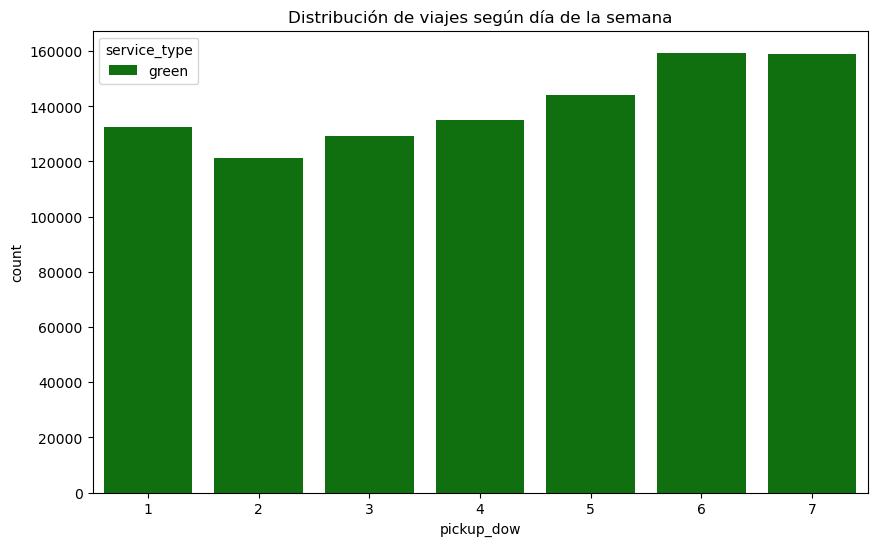

In [20]:
# ver la distribucion de viajes segun dia de la semana
plt.figure(figsize=(10, 6))
palette = {'green': 'green', 'yellow': 'yellow'}
sns.countplot(data=df_all_green_dn, x='pickup_dow', hue='service_type', palette=palette)
plt.title('Distribución de viajes según día de la semana')
plt.show()

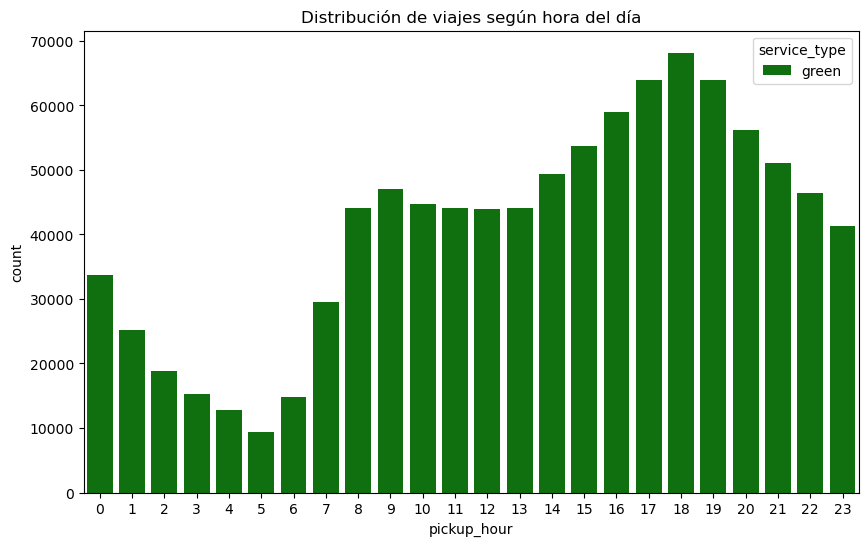

In [21]:
# ver distribucion de viajes segun hora del dia
plt.figure(figsize=(10, 6))
# poner una barra verde para green y amarilla para yellow
palette = {'green': 'green', 'yellow': 'yellow'}
sns.countplot(data=df_all_green_dn, x='pickup_hour', hue='service_type', palette=palette)
plt.title('Distribución de viajes según hora del día')
plt.show()

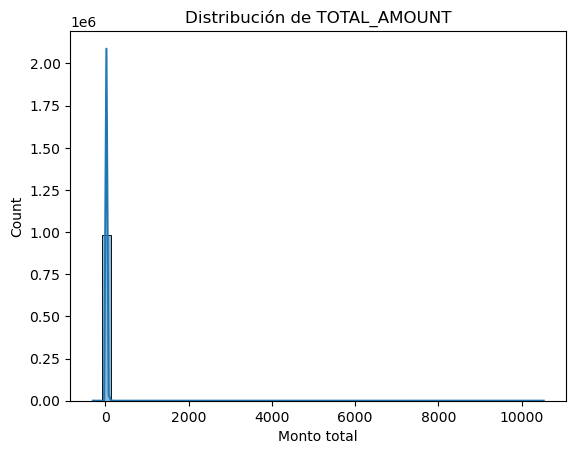

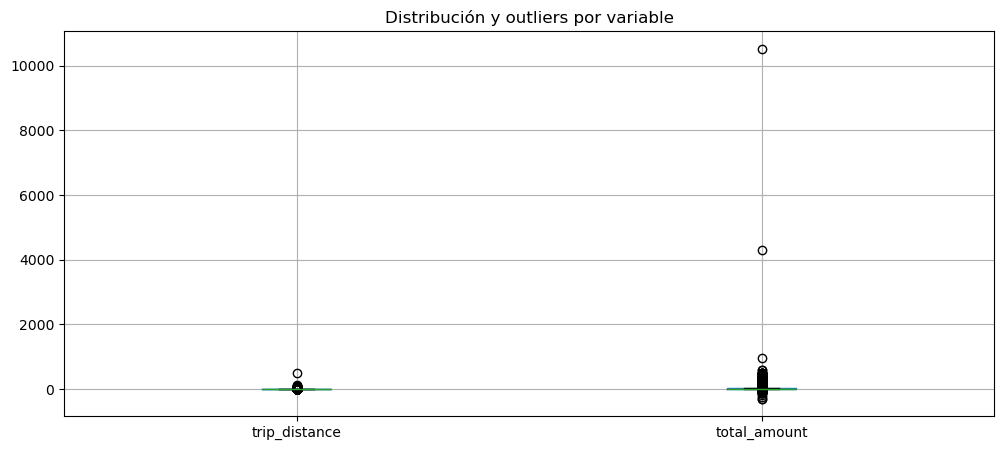

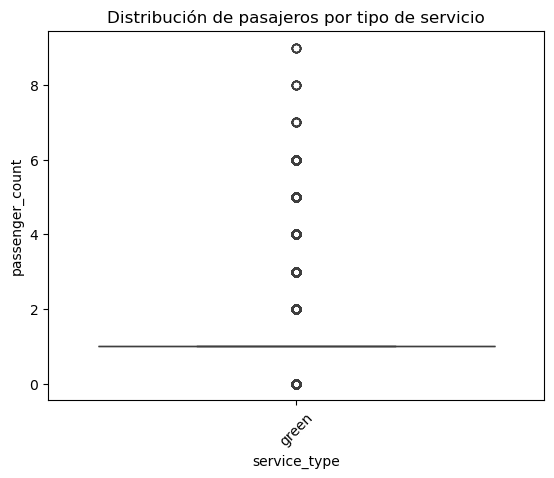

In [22]:
#Ver outliers 
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_all_green_dn["total_amount"], bins=50, kde=True)
plt.title("Distribución de TOTAL_AMOUNT")
plt.xlabel("Monto total")
plt.show()

plt.figure(figsize=(12, 5))
df_all_green_dn[['trip_distance', 'total_amount']].boxplot()
plt.title("Distribución y outliers por variable")
plt.show()

sns.boxplot(data=df_all_green_dn, x="service_type", y="passenger_count")
plt.title("Distribución de pasajeros por tipo de servicio")
plt.xticks(rotation=45)
plt.show()

In [24]:
#Descriptivas para outliners
df_all_green_dn.describe()


,trip_distance,passenger_count,total_amount,pickup_dow,pickup_month,pickup_year,pickup_hour
count,980461.000000,980461.000000,980461.000000,980461.000000,980461.000000,980461.000000,980461.000000
mean,2.984558,1.344441,15.130777,4.175239,3.554055,2017.471808,13.713563
std,3.390584,1.014743,16.589870,2.017019,2.524242,1.110261,6.246668
min,0.000000,0.000000,-300.000000,1.000000,1.000000,2016.000000,0.000000
25%,1.020000,1.000000,8.000000,2.000000,1.000000,2016.000000,9.000000
50%,1.840000,1.000000,11.300000,4.000000,3.000000,2017.000000,15.000000
75%,3.600000,1.000000,17.800000,6.000000,4.000000,2018.000000,19.000000
max,482.800000,9.000000,10528.800000,7.000000,10.000000,2019.000000,23.000000


In [25]:
categorical = ['vendor_name', 'rate_code_desc','service_type','pickup_zone','pickup_borough']
for col in categorical:
    print(f"\n{col}:")
    print(df_all_green_dn[col].value_counts())


vendor_name:
vendor_name
Curb Mobility, LLC                   800562
Creative Mobile Technologies, LLC    179899
Name: count, dtype: int64

rate_code_desc:
rate_code_desc
Standard rate            944155
Negotiated fare           33064
JFK                        2073
Nassau or Westchester       644
Newark                      499
Group ride                   16
Null/unknown                 10
Name: count, dtype: int64

service_type:
service_type
green    980461
Name: count, dtype: int64

pickup_zone:
pickup_zone
East Harlem North            59927
Central Harlem               53934
East Harlem South            53363
Astoria                      45279
Elmhurst                     40013
                             ...  
Clinton East                     1
Times Sq/Theatre District        1
SoHo                             1
Great Kills                      1
Lincoln Square East              1
Name: count, Length: 245, dtype: int64

pickup_borough:
pickup_borough
Brooklyn         334206
Ma

In [26]:
def clean_taxi_data_iqr(df, factor=1.5, min_price_per_mile=3.50):
    """
    Limpia datos usando el método IQR para detectar outliers
    factor: multiplicador del IQR (1.5 es estándar,3 ser más conservador)
    max_price_per_mile: umbral máximo de precio por milla para eliminar outliers
    min_price_per_mile: umbral mínimo de precio por milla para eliminar outliers
    """
    df_clean = df.copy()
    df_clean = df_clean.dropna()
    # Quitar 'N/A' y 'unknown' de pickup_borough
    df_clean = df_clean[(df_clean['pickup_borough'] != 'N/A') & (df_clean['pickup_borough'] != 'Unknown')]
    # Vendor name solo 1,2,6,7
    df_clean = df_clean[(df_clean['vendor_name'].isin(['Creative Mobile Technologies, LLC','Curb Mobility, LLC','Myle Technologies Inc','Helix']))]
    # Rate code desc solo 1 a 6
    df_clean = df_clean[(df_clean['rate_code_desc'].isin(['Standard rate','JFK','Newark',' Nassau or Westchester','Negotiated fare','Group ride','Null/unknown']))]
    df_clean = df_clean[(df_clean["passenger_count"] > 0) & (df_clean["passenger_count"] <= 6)] 

    # Primero eliminar valores imposibles
    df_clean = df_clean[(df_clean['trip_distance'] > 0)]
    df_clean = df_clean[(df_clean['total_amount'] > 3)]
    
    # eliminar outliers basados en precio por milla
    df_clean['price_per_mile'] = df_clean['total_amount'] / df_clean['trip_distance']
    df_clean = df_clean[(df_clean['price_per_mile'] >= min_price_per_mile)]

    # drop 'price_per_mile' column
    df_clean = df_clean.drop(columns=['price_per_mile'])
    
    # Limipar trip distance usando IQR
    Q1 = df_clean['trip_distance'].quantile(0.25)
    Q3 = df_clean['trip_distance'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df_clean = df_clean[(df_clean['trip_distance'] >= lower_bound) & (df_clean['trip_distance'] <= upper_bound)]

    # Limpiar total_amount usando IQR
    Q1 = df_clean['total_amount'].quantile(0.25)
    Q3 = df_clean['total_amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df_clean = df_clean[(df_clean['total_amount'] >= lower_bound) & (df_clean['total_amount'] <= upper_bound)]
    
    return df_clean

df_all_green_dn_clean = clean_taxi_data_iqr(df_all_green_dn, factor=3)


In [27]:
df_all_green_dn_clean

,vendor_name,trip_distance,passenger_count,rate_code_desc,total_amount,service_type,pickup_dow,pickup_month,pickup_year,pickup_hour,is_weekend,is_rush_hour,pickup_zone,pickup_borough
0,"Curb Mobility, LLC",0.63,1.0,Standard rate,5.80,green,6,1,2016,0,False,False,Steinway,Queens
1,"Curb Mobility, LLC",1.61,1.0,Standard rate,9.30,green,6,1,2016,0,False,False,Crown Heights South,Brooklyn
3,"Creative Mobile Technologies, LLC",5.50,1.0,Standard rate,19.30,green,6,1,2016,0,False,False,East Williamsburg,Brooklyn
4,"Creative Mobile Technologies, LLC",4.40,1.0,Standard rate,19.30,green,6,1,2016,0,False,False,Williamsburg (South Side),Brooklyn
5,"Curb Mobility, LLC",5.22,1.0,Standard rate,18.30,green,6,1,2016,0,False,False,East Harlem South,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980456,"Curb Mobility, LLC",1.16,1.0,Standard rate,9.80,green,5,5,2019,15,False,False,Central Park,Manhattan
980457,"Curb Mobility, LLC",1.54,1.0,Standard rate,11.16,green,5,5,2019,15,False,False,East Harlem North,Manhattan
980458,"Curb Mobility, LLC",1.87,1.0,Standard rate,15.30,green,5,5,2019,15,False,False,Crown Heights North,Brooklyn
980459,"Creative Mobile Technologies, LLC",0.80,2.0,Standard rate,6.30,green,5,5,2019,15,False,False,East Harlem North,Manhattan


In [28]:
#Categorical featuring

umbral = 1000
frecuencias_rate = df_all_green_dn_clean['rate_code_desc'].value_counts()

# Identificamos las categorías raras que están por debajo del umbral
categorias_raras_rate = frecuencias_rate[frecuencias_rate < umbral].index.tolist()

# --- 3. Remplazar categorías raras por 'Rare_Borough' ---
# Aplicamos el reemplazo de las raras directamente sobre la columna original.
df_all_green_dn_clean['rate_code_desc'].replace(
    categorias_raras_rate, 'Other', inplace=True
)

umbral_borough = 10000
frecuencias_borough = df_all_green_dn_clean['pickup_borough'].value_counts()

# Identificamos las categorías raras que están por debajo del umbral
categorias_raras_borough = frecuencias_borough[frecuencias_borough < umbral_borough].index.tolist()

# --- 3. Remplazar categorías raras por 'Rare_Borough' ---
# Aplicamos el reemplazo de las raras directamente sobre la columna original.
df_all_green_dn_clean['pickup_borough'].replace(
    categorias_raras_borough, 'Other', inplace=True
)

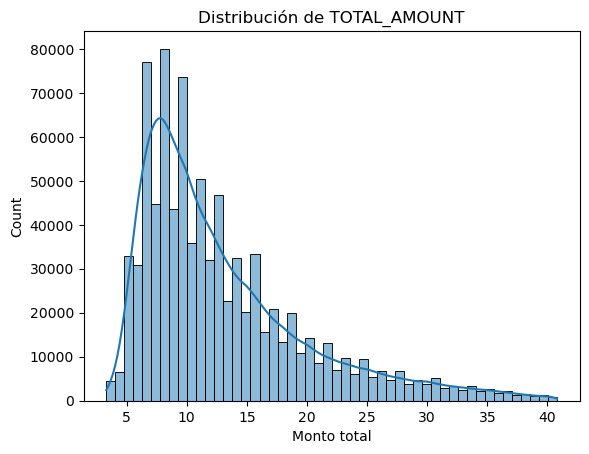

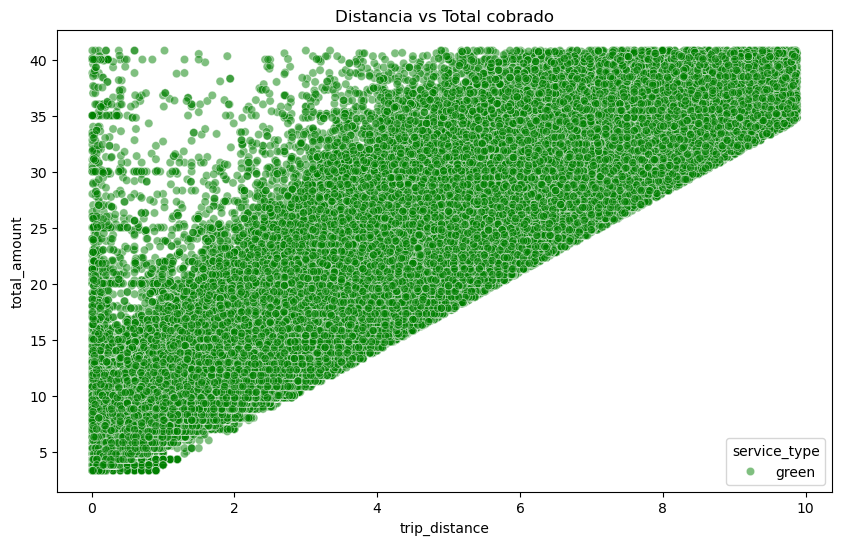

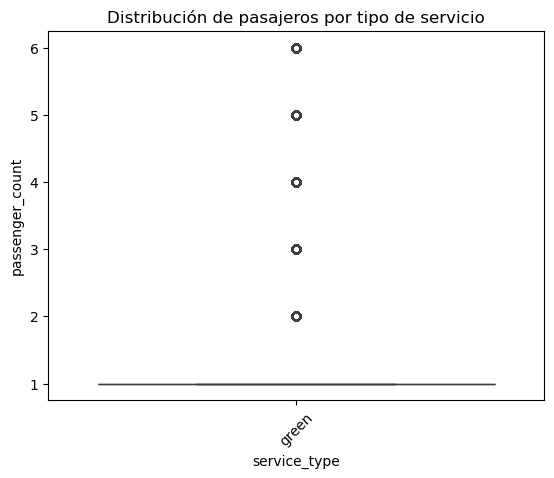

In [29]:
# graficar nuevamente
sns.histplot(df_all_green_dn_clean["total_amount"], bins=50, kde=True)
plt.title("Distribución de TOTAL_AMOUNT")
plt.xlabel("Monto total")
plt.show()

# poner yellow y green en scatterplot
plt.figure(figsize=(10, 6))
palette = {'green': 'green', 'yellow': 'yellow'}
sns.scatterplot(data=df_all_green_dn_clean, x="trip_distance", y="total_amount", alpha=0.5, hue="service_type", palette=palette)
plt.title("Distancia vs Total cobrado")
plt.show()

sns.boxplot(data=df_all_green_dn_clean, x="service_type", y="passenger_count")
plt.title("Distribución de pasajeros por tipo de servicio")
plt.xticks(rotation=45)
plt.show()

In [31]:
df_all_green_dn_clean = df_all_green_dn_clean.drop(columns=['trip_distance','service_type','pickup_zone'])
df_all_green_dn_clean.to_parquet(path="df_all_green_dn_clean.parquet", index=False)